# Automatic detection of anomalies in MONROE data

### Description of the notebook

This notebook provides methods for automatic detection of anomalies in MONROE data. It also enables visualisation of anomalies within all data. Additionally, dataframe with anomalies can be stored to a file and further analysed with tools such as Orange.

### Instructions for use

1. Run all cells under headings Import packages and connect to the database, Anomaly detection methods, and Menu widgets.
2. Run first cell under heading Get and plot selected dataframe.
3. Run cell under heading Display menu widgets.

Use the GUI to select which data is visualised and scanned for anomalies. You can input optional arguments in text box named arguments, thus controlling various parameters in calculation of the anomalies. The parameters are described in the docstrings of methods for detecting anomalies.

To store the dataframe with identified anomalies to a file, run function sdf.transform_store_df (cell above header Display menu widgets).

### Import packages and connect to the database

In [1]:
%matplotlib notebook

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

import ricercando as ric
import ast
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats
import ipywidgets as ipw
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

# connect to ricercando database
database_ip = '192.168.27.75'
ric.set_connection_params(host=database_ip)

### Anomaly detection methods 

#### Select detector

In [2]:
# run selected detector
method_list = ['baseline', 'rolling window']

def select_detector(method_name=None, df=None, observed_parameter=None, arguments='', *args, **kwargs):
    r"""
    Select anomaly detection method by its name and analyse df.
    If method name is not available, return list of available methods.

    Parameters
    ----------
    method_name : str
        Name of the anomaly detection method.
    df : dataframe
        Dataframe to analyse.
    observed_parameter : str
        Name of the observed parameter column in df.
    arguments : str
        String with arguments for anomaly detection method.
    *args, **kwargs
        Arbitrary optional arguments.
        
    Returns
    -------
    list of dataframes
        Each dataframe in list contains outliers on some time interval.
    """
    # convert string arguments to list arg_list and dictionary arg_dict
    if arguments != '':
        arguments_list = arguments.split(',')
        arg_list = [ast.literal_eval(arg) for arg in arguments_list if '=' not in arg]
        arg_dict = {key: ast.literal_eval(value) for [key, value] in [kwarg.split('=') for kwarg in arguments_list if '=' in kwarg]}
    else:
        arg_list = []
        arg_dict = {}

    # select method rolling window
    if method_name == method_list[0]:
        return baseline(df, observed_parameter, *arg_list, **arg_dict)
    # select method rolling window
    elif method_name == method_list[1]:
        return rolling_window(df, observed_parameter, *arg_list, **arg_dict)
    # return list of available methods
    else:
        return method_list

In [3]:
# get dataframes with outliers and mark regions with anomalies on plot
def get_df_outliers(df, observed_parameter, outliers, *args, **kwargs):
    r"""
    Get list containing the dataframes with outliers and mark regions with anomalies on plot.

    Parameters
    ----------
    df : dataframe
        Dataframe to analyse.
    observed_parameter : str
        Name of the observed parameter column in df.
    outliers : dataframe
        Dataframe with outliers.

    optional arguments in args or kwargs
    time_delta : pandas.Timedelta
        Anomaly region contains consecutive outliers that are at most time_delta apart.
    min_df_size : int
        Minimal number of samples required for a dataframe with outliers.

    Returns
    -------
    list of dataframes
        Each dataframe in list contains outliers on some time interval.
    """
    edgecolor = '#d5b60a'
    facecolor = '#fffe7a'

    # default values for required arguments
    default_resolution = '10min'
    default_time_delta = pd.Timedelta(default_resolution)
    default_min_df_size = int(np.ceil(df.shape[0] * default_resolution / (df.index.max() - df.index.min())))

    args = list(args)
    # get time_delta value
    if args:
        time_delta = args.pop(0)
    elif 'time_delta' in kwargs:
        time_delta = kwargs.pop('time_delta')
    else:
        time_delta = default_time_delta
    # get min_df_size value
    if args:
        min_df_size = args.pop(0)
    elif 'min_df_size' in kwargs:
        min_df_size = kwargs.pop('min_df_size')
    else:
        min_df_size = default_min_df_size


    df_outliers_list = []
    # start first anomaly region
    current_region = []
    start_index = previous_index = outliers.index.min()
    # add label 'anomaly region'
    plt.gca().add_patch(ptc.Rectangle((start_index, plt.ylim()[0]), 0, 0, linewidth=0, facecolor=facecolor, label='anomaly region'))
    for index, value in outliers.iteritems():
        # end anomaly region
        if index - time_delta > previous_index:
            if len(current_region) >= min_df_size:
                df_outliers_list.append(df.loc[current_region])
                # mark regions with anomalies on plot
                min_outlier_value = df_outliers_list[-1][observed_parameter].min()
                plt.gca().add_patch(ptc.Rectangle(
                    (start_index, min_outlier_value), (previous_index - start_index).total_seconds()/(24*3600),
                    df_outliers_list[-1][observed_parameter].max() - min_outlier_value,
                    alpha=0.3, linewidth=1, edgecolor=edgecolor, facecolor=facecolor))
            # start new anomaly region
            current_region = []
            start_index = index
            current_region.append(index)
        # value is in the current anomaly region
        else:
            current_region.append(index)

        previous_index = index

    # end anomaly region
    if len(current_region) >= min_df_size:
        df_outliers_list.append(df.loc[current_region])
        # mark regions with anomalies on plot
        min_outlier_value = df_outliers_list[-1][observed_parameter].min()
        plt.gca().add_patch(ptc.Rectangle(
            (start_index, min_outlier_value), (previous_index - start_index).total_seconds()/(24*3600),
            df_outliers_list[-1][observed_parameter].max() - min_outlier_value,
            alpha=0.3, linewidth=1, edgecolor=edgecolor, facecolor=facecolor))

    return df_outliers_list

#### Baseline detector

In [4]:
def baseline(df, observed_parameter, *args, **kwargs):
    r"""
    Determine the baseline of the observed parameter regarding other parameter(s).
    Detect and plot anomalies with respect to the baseline.

    Parameters
    ----------
    df : dataframe
        Dataframe to analyse.
    observed_parameter : str
        Name of the observed parameter column in df.

    optional arguments in args or kwargs
    bl_ind_param : str
        Determine the baseline of the observed parameter regarding independent parameter bl_ind_param.
    bl_ind_param_dec : bool
        True if bl_ind_param is decreasing, i.e. smaller values are better (e.g. RTT).

    optional arguments only in kwargs
    bl_k1 : numeric
        Coefficient in expression to determine the baseline.
        Every base value is the mean of best 100*bl_k1 percent samples for each value of the independent parameter.
    bl_k2 : numeric
        Coefficient in expression to determine outliers.
        Sample is an outlier when it is more than a factor of bl_k2 worse than baseline.
        Worse means larger if bl_ind_param_dec=True and smaller otherwise.
    bl_time_delta : pandas.Timedelta
        Anomaly region contains consecutive outliers that are at most time_delta apart.
    bl_min_df_size : int
        Minimal number of samples required for a dataframe with outliers.

    Returns
    -------
    list of dataframes
        Each dataframe in list contains outliers on some time interval.
    """
    baseline_color = '#d8dcd6'

    # statistic cannot be calculated on categorical object
    if type(df[observed_parameter].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
        return []

    # default values for required arguments
    default_ind_param = 'RSSI'
    default_ind_param_dec = True
    default_k1 = .1
    default_k2 = 1.1
    default_resolution = '10min'
    default_time_delta = pd.Timedelta(default_resolution)
    default_min_df_size = int(np.ceil(df.shape[0] * default_resolution / (df.index.max() - df.index.min())))

    args = list(args)
    # get independent parameter
    if args:
        ind_param = args.pop(0)
    elif 'bl_ind_param' in kwargs:
        ind_param = kwargs.pop('bl_ind_param')
    else:
        ind_param = default_ind_param
    # get ind_param_dec value
    if args:
        ind_param_dec = args.pop(0)
    elif 'bl_ind_param_dec' in kwargs:
        ind_param_dec = kwargs.pop('bl_ind_param_dec')
    else:
        ind_param_dec = default_ind_param_dec
    # get k1 value
    if 'bl_k1' in kwargs:
        k1 = kwargs.pop('bl_k1')
    else:
        k1 = default_k1
    # get k2 value
    if 'bl_k2' in kwargs:
        k2 = kwargs.pop('bl_k2')
    else:
        k2 = default_k2
    # get time_delta value
    if 'time_delta' in kwargs:
        time_delta = kwargs.pop('time_delta')
    else:
        time_delta = default_time_delta
    # get min_df_size value
    if 'min_df_size' in kwargs:
        min_df_size = kwargs.pop('min_df_size')
    else:
        min_df_size = default_min_df_size


    # determine and plot the baseline

    # base values of the observed parameter for each value of the independent parameter
    # every base value is the mean of best k1 * all values in the group
    df_baseline = df.groupby(ind_param)[observed_parameter].agg(
        lambda x: x.nsmallest(int(np.ceil(k1 * x.count()))).mean() if ind_param_dec else x.nlargest(int(np.ceil(k1 * x.count()))).mean())
    df_baseline_pad = df_baseline[df[ind_param].fillna(method='pad')]
    plt.plot(df.index, df_baseline_pad, color='black', label='baseline')


    # find and plot outliers

    # sample is an outlier when it is more than a factor of k2 worse than baseline
    if ind_param_dec:
        mask = df.reset_index()[observed_parameter] > k2 * df_baseline_pad.reset_index()[observed_parameter]
    else:
        mask = df.reset_index()[observed_parameter] < k2 * df_baseline_pad.reset_index()[observed_parameter]
    mask = pd.DataFrame(mask).assign(new_index=df.index).set_index('new_index')
    outliers = df[observed_parameter][mask[observed_parameter]]

    # plot outliers
    plt.scatter(outliers.index, outliers, s=1, color='r', label='outliers')
    # get dataframes with outliers and mark regions with anomalies on plot
    df_outliers_list = get_df_outliers(df, observed_parameter, outliers, time_delta, min_df_size)
    plt.legend(loc='upper right')


    # plot independent parameter vs base values of the observed parameter

#     display(df.groupby(ind_param)[observed_parameter].count())
    plt.figure(num='node id={0}, iccid={1} baseline'.format(df['NodeId'][0], df['Iccid'][0]), tight_layout=True)
    if type(df_baseline.index) is pd.core.indexes.category.CategoricalIndex:
        plt.scatter(df_baseline.index.categories.astype('str'), df_baseline)
        plt.xticks(range(len(df_baseline.index.categories)), df_baseline.index.categories)
    else:
        plt.scatter(df_baseline.index, df_baseline)
    plt.xlabel(ind_param)
    plt.ylabel(observed_parameter)

#     display(df_outliers_list)
    return df_outliers_list

#### Rolling window detector

In [5]:
def rolling_window(df, observed_parameter, *args, **kwargs):
    r"""
    Compute rolling window calculations and plot anomalies.

    Parameters
    ----------
    df : dataframe
        Dataframe to analyse.
    observed_parameter : str
        Name of the observed parameter column in df.
        
    optional arguments in args or kwargs
    rw_calc : str
        Rolling calculation to perform.
    rw_res : str in pandas.Timestamp format
        Temporal resolution of anomalies.
        Minimal length of the time interval that contains anomalies.
    rw_k1 : numeric
        Coefficient in expression to determine maximal separation between consecutive outliers in anomaly region.
        maximal separation = rw_k1 * rw_res
    rw_k2 : numeric
        Coefficient in expression to determine minimal size of a dataframe with outliers.
        min_df_size = rw_k2 * number of samples in a window of size rw_res

    optional arguments only in kwargs
    rw_k1_std : int
        Coefficient in expression to determine rolling window size when rw_calc=std.
        rolling window size = rw_k1_std * rw_res
    rw_k2_std : numeric
        Coefficient in expression to determine outliers when rw_calc=std.
        Sample is an outlier when abs(value(sample) - rw_mean) > rw_k2_std * rw_std.
    rw_k1_mean : numeric
        Coefficient in expression to determine outliers when rw_calc=mean.
        Sample is an outlier when abs((rw_mean shifted by 1) - rw_mean) > rw_k1_mean * rw_mean,
        i.e. rw_mean changes for more than 100*rw_k1_mean percent.
    rw_k1_dist : int
        Coefficient in expression to determine rolling window size when rw_calc=dist.
        rolling window size = rw_k1_dist * rw_res

    Returns
    -------
    list of dataframes
        Each dataframe in list contains outliers on some time interval.
    """
    linecolor = '#d8dcd6'
    bold_linecolor = '#000000'

    # statistic cannot be calculated on categorical object
    if type(df[observed_parameter].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
        return []

    # default values for required arguments
    default_calculation = 'std'
    default_resolution = '10min'
    default_k1 = {'std': 0.5, 'mean': 0.5, 'dist': 0.5}
    default_k2 = {'std': 0.5, 'mean': 1, 'dist': 1}
    default_k1_std = 18
    default_k2_std = 3
    default_k1_mean = 0.002
    default_k1_dist = 6

    args = list(args)
    # get calculation value
    if args:
        calculation = args.pop(0)
    elif 'rw_calc' in kwargs:
        calculation = kwargs.pop('rw_calc')
    else:
        calculation = default_calculation
    # get resolution value
    if args:
        resolution = args.pop(0)
    elif 'rw_res' in kwargs:
        resolution = kwargs.pop('rw_res')
    else:
        resolution = default_resolution
    # get k1 value
    if args:
        k1 = args.pop(0)
    elif 'rw_k1' in kwargs:
        k1 = kwargs.pop('rw_k1')
    else:
        k1 = default_k1.get(calculation)
    # get k2 value
    if args:
        k2 = args.pop(0)
    elif 'rw_k2' in kwargs:
        k2 = kwargs.pop('rw_k2')
    else:
        k2 = default_k2.get(calculation)


    # compute rolling window calculation

    # calculate rolling standard deviation
    # sample is an outlier when abs(value(sample) - rw_mean) > k2_std * rw_std
    if calculation == 'std':
        # get k1_std value
        if 'rw_k1_std' in kwargs:
            k1_std = kwargs.pop('rw_k1_std')
        else:
            k1_std = default_k1_std
        # get k2_std value
        if 'rw_k2_std' in kwargs:
            k2_std = kwargs.pop('rw_k2_std')
        else:
            k2_std = default_k2_std

        rw_mean = df[observed_parameter].rolling(k1_std * resolution, *args, **kwargs).mean()
        rw_std = df[observed_parameter].rolling(k1_std * resolution, *args, **kwargs).std()

        # samples not between rw_high and rw_low are outliers
        rw_high = rw_mean + k2_std * rw_std
        rw_low = rw_mean - k2_std * rw_std
        outliers = df[observed_parameter][abs(df[observed_parameter] - rw_mean) > k2_std * rw_std]

        # plot rolling window calculation
        plt.fill_between(rw_high.index, rw_high, rw_low, alpha=0.5, facecolor=linecolor, label='rolling ' + calculation)

    # calculate rolling mean
    # sample is an outlier when abs((rw_mean shifted by 1) - rw_mean) > k1_mean * rw_mean
    elif calculation == 'mean':
        # get k1_mean value
        if 'rw_k1_mean' in kwargs:
            k1_mean = kwargs.pop('rw_k1_mean')
        else:
            k1_mean = default_k1_mean

        rw_mean = df[observed_parameter].rolling(resolution, *args, **kwargs).mean()
        # outliers lie on time interval where rw_mean changes by more than a factor of k1_mean
        mask = abs(rw_mean.shift(1) - rw_mean) > k1_mean * rw_mean
        outliers = df[observed_parameter][mask]

        # plot rolling window calculation
        plt.plot(rw_mean.index, rw_mean, color=linecolor, label='rolling ' + calculation)
        plt.plot(rw_mean.index, rw_mean.where(mask), color=bold_linecolor, label='_nolegend_')

    # calculate rolling distribution
    elif calculation == 'dist':
        # get k1_dist value
        if 'rw_k1_dist' in kwargs:
            k1_dist = kwargs.pop('rw_k1_dist')
        else:
            k1_dist = default_k1_dist

        start_index = df.index.min()
        offset = k1_dist * pd.Timedelta(resolution)
        end_index = start_index + offset
        while end_index <= df.index.max():
            kernel = stats.gaussian_kde(df[observed_parameter][start_index : end_index].fillna(0))
            stats.kstest(kernel.dataset, 'norm')

#             z = df[observed_parameter][start_index : end_index].reset_index().fillna(0)
#             display(z[observed_parameter])
#             z[observed_parameter].plot(kind='hist')

            start_index += pd.Timedelta(resolution)
            end_index = start_index + offset

        outliers = pd.DataFrame()

    # invalid calculation
    else:
        return []

    # plot outliers
    plt.scatter(outliers.index, outliers, s=1, color='r', label='outliers')

    # get dataframes with outliers and mark regions with anomalies on plot
    time_delta = k1 * pd.Timedelta(resolution)
    min_df_size = int(k2 * np.ceil(df.shape[0] * resolution / (df.index.max() - df.index.min())))
    df_outliers_list = get_df_outliers(df, observed_parameter, outliers, time_delta, min_df_size)

    plt.legend(loc='upper right')
#     display(df_outliers_list)
    return df_outliers_list

### Menu widgets

In [6]:
label1_width = '130px'
label23_width = '110px'
widget12_width = '150px'
nodeid_default = '597'
observedparameter_default = 'RTT'
startdate_default = dt.datetime(2017, 10, 13)
# could be startdate_default = dt.date(2017, 10, 13) with newer packages

# widgets for selecting dataframe
# column 1

nodeid_dropdown = ipw.Dropdown(options=ric.all_nodes(), value=nodeid_default, layout=ipw.Layout(width=widget12_width))
nodeid_box = ipw.HBox([ipw.Label('node id', layout=ipw.Layout(width=label1_width)), nodeid_dropdown])

observedparameter_dropdown = ipw.Dropdown(options=list(ric.getdf(ric.tables_for_node(nodeid_dropdown.value), nodeid=nodeid_dropdown.value, limit=1)),
                                          value=observedparameter_default, layout=ipw.Layout(width=widget12_width))
observedparameter_box = ipw.HBox([ipw.Label('observed parameter', layout=ipw.Layout(width=label1_width)), observedparameter_dropdown])

temporalresolution_dropdown = ipw.Dropdown(options=['default', '10 milliseconds', '1 second', '1 minute', '30 minutes'],
                                           value='default', layout=ipw.Layout(width=widget12_width))
temporalresolution_box = ipw.HBox([ipw.Label('temporal resolution', layout=ipw.Layout(width=label1_width)), temporalresolution_dropdown])

# column 2

startdate_datepicker = ipw.DatePicker(value=startdate_default, layout=ipw.Layout(width=widget12_width))
startdate_box = ipw.HBox([ipw.Label('start date', layout=ipw.Layout(width=label23_width)), startdate_datepicker])

starthour_intslider = ipw.IntSlider(min=0, max=23, step=1, value=0, continuous_update=False, layout=ipw.Layout(width=widget12_width))
starthour_box = ipw.HBox([ipw.Label('start hour', layout=ipw.Layout(width=label23_width)), starthour_intslider])

timespan_inttext = ipw.IntText(value=24, continuous_update=False, layout=ipw.Layout(width=widget12_width))
timespan_box = ipw.HBox([ipw.Label('time span [hours]', layout=ipw.Layout(width=label23_width)), timespan_inttext])

# widgets for selecting anomaly detection method
# column 3

detector_dropdown = ipw.Dropdown(options=['none'] + method_list, value=method_list[0])
detector_box = ipw.HBox([ipw.Label('anomaly detector', layout=ipw.Layout(width=label23_width)), detector_dropdown])

arguments_text = ipw.Text(placeholder='arguments for detector', continuous_update=False)
arguments_box = ipw.HBox([ipw.Label('arguments', layout=ipw.Layout(width=label23_width)), arguments_text])

showplot_button = ipw.Button(description='Show plot')


def handle_widget_change_new_df(change):
    r"""
    Observe the change of a widget value.
    Get new selected dataframe.
    """
    sdf.get_selected_df()
    sdf.plot_df()


def handle_widget_change_keep_df(change):
    r"""
    Observe the change of a widget value.
    Keep current dataframe unless it is None.
    """
    if sdf.df is None:
        sdf.get_selected_df()
    sdf.plot_df()


def handle_nodeid_change(change):
    r"""
    Observe the change of nodeid Dropdown value.
    Different node is selected, so its possible parameters list (from tables_for_node) must be updated.
    """
    # temporarily unobserve handle_widget_change_keep_df, otherwise it is executed after this function
    observedparameter_dropdown.unobserve(handle_widget_change_keep_df, names='value')
    observedparameter_dropdown.options = list(ric.getdf(ric.tables_for_node(nodeid_dropdown.value), nodeid=nodeid_dropdown.value, limit=1))
    if not observedparameter_dropdown.options:
        observedparameter_dropdown.value = None
    elif observedparameter_default in observedparameter_dropdown.options:
        observedparameter_dropdown.value = observedparameter_default
    else:
        observedparameter_dropdown.value = observedparameter_dropdown.options[0]
    observedparameter_dropdown.observe(handle_widget_change_keep_df, names='value')

    sdf.get_selected_df()
    sdf.plot_df()


# register callbacks executed on value change
nodeid_dropdown.observe(handle_nodeid_change, names='value')
observedparameter_dropdown.observe(handle_widget_change_keep_df, names='value')
temporalresolution_dropdown.observe(handle_widget_change_new_df, names='value')
startdate_datepicker.observe(handle_widget_change_new_df, names='value')
starthour_intslider.observe(handle_widget_change_new_df, names='value')
timespan_inttext.observe(handle_widget_change_new_df, names='value')
detector_dropdown.observe(handle_widget_change_keep_df, names='value')
arguments_text.observe(handle_widget_change_keep_df, names='value')
showplot_button.on_click(handle_widget_change_keep_df)

### Get and plot selected dataframe

In [7]:
class SelectedDataframe():
    r"""Contains the selected dataframe to analyse."""

    freq_map = {'default': None, '10 milliseconds': '10ms', '1 second': '1s', '1 minute': '1m', '30 minutes': '30m'}

    def __init__(self):
        self.df = None
        self.df_outliers_list = []

        
    def groupby_iccid(self):
        if 'Iccid' in self.df.columns:
            self.df_group = self.df.groupby('Iccid')
        else:
            self.df_group = None


    def store_df(self):
        r"""Store df to file."""
        pd.to_pickle(self.df, 'stored_df')


    def restore_df(self, filename='stored_df'):
        r"""Restore df from file."""
        try:
            self.df = pd.read_pickle(filename)
            self.groupby_iccid()
        except FileNotFoundError:
            print('File {0} not found.'.format(filename))


    def transform_store_df(self):
        r"""
        Transform and store dataframe to file for further analysis.
        1. Add column 'observed parameter'_OK filled with value=False to every dataframe in df_outliers_list.
        2. Add column anomaly_id with value=(index + 1) to every dataframe in df_outliers_list.
        3. Fill column 'observed parameter'_OK with value=True for samples in df_OK = (df - all df_outliers).
        4. Fill column anomaly_id with value=Nan for samples in df_OK.
        5. Concatenate df_OK + all df_outliers to df_all.
        6. Pad anomaly_id: anomaly_id determines a region with anomalies on some time interval and a region
            without anomalies on subsequent time interval.
        7. Store resulting dataframe to file.
        """
        # add column 'observed parameter'_OK filled with value=False to every dataframe with outliers
        self.df_outliers_list = [df_outlier.assign(
            new_column=pd.Categorical([False] * df_outlier.shape[0], categories=[True, False])).rename(
            index=str, columns={'new_column' : '{0}_OK'.format(observedparameter_dropdown.value)}) for df_outlier in self.df_outliers_list]
        # add column anomaly_id with value=(index + 1) to every dataframe with outliers
        self.df_outliers_list = [df_outlier.assign(anomaly_id=pd.Categorical(
            [idx + 1] * df_outlier.shape[0], categories=range(len(self.df_outliers_list) + 1))) for idx, df_outlier in enumerate(self.df_outliers_list)]

        df_outliers = pd.concat(self.df_outliers_list)
        df_OK = self.df[~self.df.index.isin(df_outliers.index)]
        # add and fill column 'observed parameter'_OK with value=True for samples in df_OK
        df_OK = df_OK.assign(new_column=pd.Categorical([True] * df_OK.shape[0], categories=[True, False])).rename(
            index=str, columns={'new_column' : '{0}_OK'.format(observedparameter_dropdown.value)})
        # add and fill column anomaly_id with value=Nan for samples in df_OK
        df_OK = df_OK.assign(anomaly_id=pd.Categorical([np.nan] * df_OK.shape[0], categories=range(len(self.df_outliers_list) + 1)))
        # concatenate df_OK + all df_outlier
        df_all = pd.concat([df_OK, df_outliers]).sort_index()
        # pad anomaly_id
        df_all['anomaly_id'].fillna(method='pad', inplace=True)
        df_all['anomaly_id'].fillna(0, inplace=True)
        # store resulting dataframe to file
        pd.to_pickle(df_all, 'df_anomalies')


    def get_selected_df(self):
        r"""
        Get selected dataframe based on values in menu widgets.
        Group dataframe by iccid and save result into DataFrameGroupBy df_group.
        """
        start_time = dt.datetime.combine(startdate_datepicker.value, dt.time(hour=starthour_intslider.value))
        end_time = start_time + dt.timedelta(hours=timespan_inttext.value)
        self.df = ric.getdf(ric.tables_for_node(nodeid_dropdown.value), nodeid=nodeid_dropdown.value, limit=None,
                            start_time=start_time, end_time=end_time, freq=self.freq_map[temporalresolution_dropdown.value])
        self.groupby_iccid()


    def plot_df(self):
        r"""Plot selected dataframes for each iccid."""
        clear_output()

#         import qgrid
#         for iccid, df_iccid in self.df_group:
#             display(iccid)
#             display(qgrid.show_grid(df_iccid, grid_options={'forceFitColumns': False}))
#             display(df_iccid)

        # comment out the command below if the menu widgets duplicate in each run
        display(menu_widgets)
        plt.close('all')
        # show plot for each iccid
        if self.df_group is not None and observedparameter_dropdown.value is not None:
            for iccid, df_iccid in self.df_group:
                plt.figure(num='node id={0}, iccid={1}'.format(nodeid_dropdown.value, iccid), tight_layout=True)
                # resolve 'could not convert string to float' error
                if type(df_iccid[observedparameter_dropdown.value].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
                    plt.scatter(df_iccid.index, df_iccid[observedparameter_dropdown.value].astype('str'), s=1, color='b')
                else:
                    plt.scatter(df_iccid.index, df_iccid[observedparameter_dropdown.value], s=1, color='b')

                plt.legend(loc='upper right')
                plt.xlabel('time')
                plt.ylabel(observedparameter_dropdown.value)
                plt.xlim(df_iccid.index.min(), df_iccid.index.max())

                # anomaly detection
                self.df_outliers_list = select_detector(detector_dropdown.value, df_iccid, observedparameter_dropdown.value, arguments_text.value)


sdf = SelectedDataframe()

In [ ]:
# read stored dataframe from a file into sdf
# sdf.store_df()
sdf.restore_df()

In [ ]:
# store dataframe for further analysis
sdf.transform_store_df()

### Display menu widgets

HBox(children=(VBox(children=(HBox(children=(Label(value='node id', layout=Layout(width='130px')), Dropdown(index=309, layout=Layout(width='150px'), options=('24', '26', '27', '30', '39', '42', '43', '44', '45', '48', '50', '53', '55', '57', '58', '59', '62', '63', '91', '92', '95', '96', '103', '106', '111', '119', '126', '127', '133', '135', '144', '145', '146', '148', '149', '150', '151', '152', '163', '171', '175', '183', '186', '187', '193', '195', '196', '197', '198', '202', '203', '204', '206', '207', '208', '209', '211', '228', '229', '232', '233', '234', '236', '237', '238', '239', '241', '247', '249', '251', '254', '255', '257', '258', '261', '264', '265', '266', '267', '274', '275', '277', '285', '289', '290', '291', '292', '295', '296', '297', '298', '299', '300', '301', '304', '305', '308', '309', '312', '314', '315', '316', '317', '320', '321', '322', '323', '324', '326', '328', '332', '333', '341', '342', '343', '346', '347', '352', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '374', '375', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '394', '395', '396', '397', '400', '401', '402', '403', '406', '407', '408', '409', '411', '412', '414', '416', '417', '418', '419', '420', '422', '423', '424', '426', '427', '428', '429', '430', '431', '432', '433', '434', '436', '437', '438', '439', '440', '441', '442', '444', '445', '446', '447', '448', '449', '450', '451', '452', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '519', '520', '544', '545', '546', '547', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571', '572', '573', '574', '575', '580', '582', '583', '584', '585', '586', '587', '588', '589', '590', '591', '592', '593', '594', '595', '596', '597', '598', '599', '600', '601'), value='597'))), HBox(children=(Label(value='observed parameter', layout=Layout(width='130px')), Dropdown(index=28, layout=Layout(width='150px'), options=('BootCounter', 'CPU_Apps', 'CPU_User', 'CumUptime', 'Swap', 'Uptime', 'bat_usb0', 'bat_usb1', 'bat_usb2', 'NodeId', 'CID', 'DeviceMode', 'DeviceState', 'ECIO', 'Frequency', 'IP_Address', 'Interface', 'MCC_MNC', 'Operator', 'RSRQ', 'RSSI', 'Iccid', 'Altitude', 'Latitude', 'Longitude', 'SatelliteCount', 'Speed', 'Host', 'RTT', 'EventType', 'Message'), value='RTT'))), HBox(children=(Label(value='temporal resolution', layout=Layout(width='130px')), Dropdown(index=3, layout=Layout(width='150px'), options=('default', '10 milliseconds', '1 second', '1 minute', '30 minutes'), value='1 minute'))))), VBox(layout=Layout(width='150px')), VBox(children=(HBox(children=(Label(value='start date', layout=Layout(width='110px')), DatePicker(value=datetime.date(2017, 10, 14), layout=Layout(width='150px')))), HBox(children=(Label(value='start hour', layout=Layout(width='110px')), IntSlider(value=0, continuous_update=False, layout=Layout(width='150px'), max=23))), HBox(children=(Label(value='time span [hours]', layout=Layout(width='110px')), IntText(value=24, layout=Layout(width='150px')))))), VBox(layout=Layout(width='150px')), VBox(children=(HBox(children=(Label(value='anomaly detector', layout=Layout(width='110px')), Dropdown(index=1, options=('none', 'baseline', 'rolling window'), value='baseline'))), HBox(children=(Label(value='arguments', layout=Layout(width='110px')), Text(value='', continuous_update=False, placeholder='arguments for detector'))), Button(description='Show plot', style=ButtonStyle())))

<IPython.core.display.Javascript object>


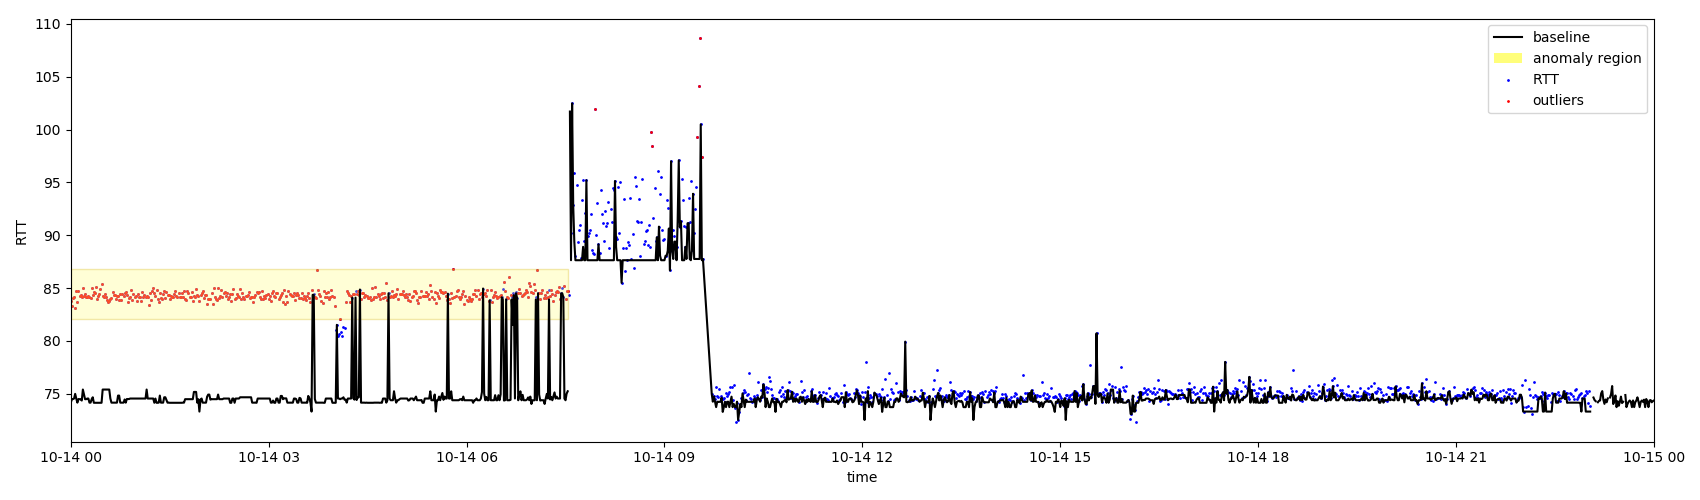

<IPython.core.display.Javascript object>


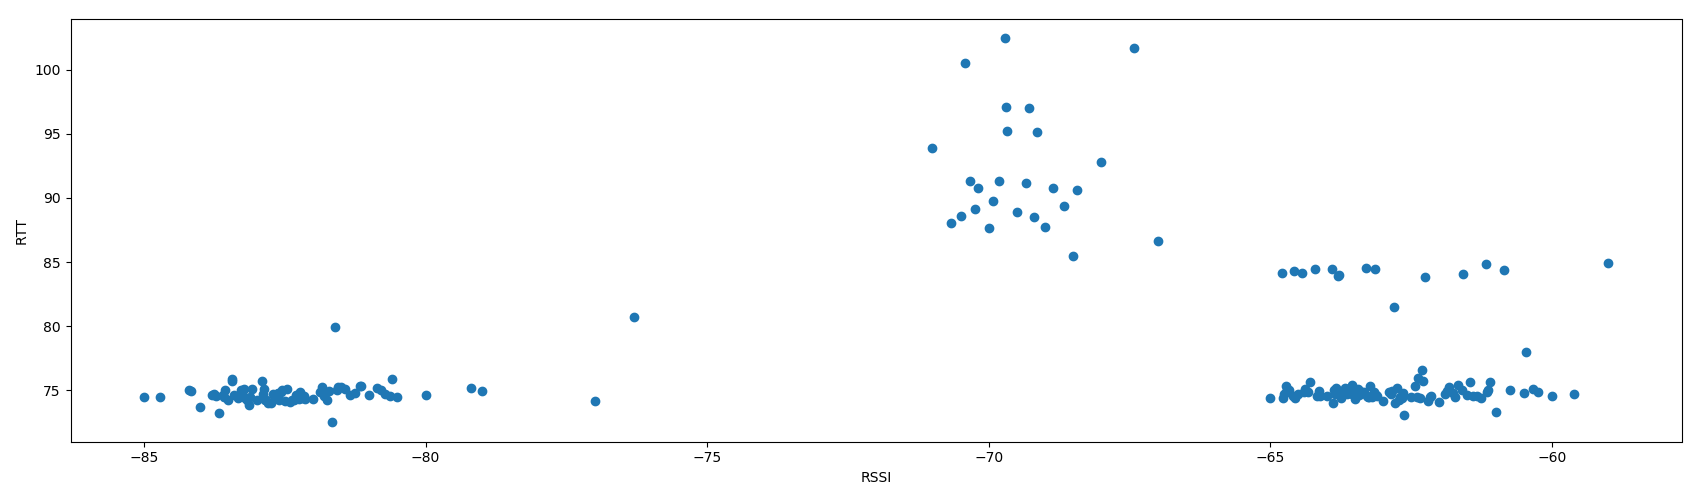

In [8]:
plt.rcParams['figure.figsize'] = 17, 5
menu_widgets = ipw.HBox([ipw.VBox([nodeid_box, observedparameter_box, temporalresolution_box]), ipw.VBox(layout=ipw.Layout(width=widget12_width)),
                         ipw.VBox([startdate_box, starthour_box, timespan_box]), ipw.VBox(layout=ipw.Layout(width=widget12_width)),
                         ipw.VBox([detector_box, arguments_box, showplot_button])])
display(menu_widgets)